In [4]:
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from regions import region
from tqdm import tqdm_notebook
from matplotlib.colors import LogNorm

# Radiocarbon $(^{14}C)$ Emissions from Nuclear Power Facilities

## Emissions over Europe (EUROCOM domain)

Emissions from nuclear power plants and reprocessing facilities over the EUROCOM domain (lat0=33, lat1=73, lon0=-15, lon1=35) compiled by Ida Storm at the Carbon Portal. The emissions were obtained from different sources. For details read Appendix A.1. of [Maier F. et al (2023)](https://royalsocietypublishing.org/doi/eprx_data/10.1098/rsta.2022.0203).

In [144]:
nuclear_emisisons_ICOS = pd.read_csv('data/radiocarbon_emissions.csv') # Radiocarbon emisisons in GBq yr-1
nuclear_emisisons_ICOS = gpd.GeoDataFrame(nuclear_emisisons_ICOS, geometry=gpd.points_from_xy(nuclear_emisisons_ICOS.longitude, nuclear_emisisons_ICOS.latitude))

In [145]:
# Define the region of interest and the resolution of the grid

area_EU = region(lat0=33, lat1=73, lon0=-15, lon1=35, dlat=0.5, dlon=0.5)

npp_time = pd.date_range('2006-01-01', '2022-01-01', freq='Y', closed='right')
npp_lat = area_EU.lats
npp_lon = area_EU.lons

# Create an empty xr.Dataset to store the NPP data
xr.set_options(keep_attrs=True)
npp = xr.Dataset()

# Create a variable to store the NPP data
npp['emis'] = xr.DataArray(
    data = np.zeros((len(npp_time), len(npp_lat), len(npp_lon))),
    dims = ['time', 'lat', 'lon'],
    coords = {'time': npp_time, 'lat': npp_lat, 'lon': npp_lon},
    attrs = {'units': 'Bq/m2/s', 
             'long_name': '14CO2 emissions from Nuclear Power Plants and Spent Fuel Reprocessing Plants',
             'description': '14CO2 emissions from Nuclear Power Plants and Spent Fuel Reprocessing Plants preprocessed by Hannah Allen (hannah.allen@lsce.ipsl.fr) and Carlos Gómez-Ortiz (carlos.gomez@nateko.lu.se) on 14-12-2023 with data from RADD and Zazzeri et al. (2018) gather and curated by Ida Storm (ICOS.storm@nateko.lu.se)',}
)

npp['emis'] = npp['emis'] / (365 * 24 * 60 * 60) # Convert from GBq yr-1 to GBq s-1
npp['emis'] = npp['emis'] * 1e9 # Convert from GBq s-1 to Bq s-1

for di, data in tqdm_notebook(nuclear_emisisons_ICOS.iterrows(), total=nuclear_emisisons_ICOS.shape[0]):

    lat = data['latitude']
    lon = data['longitude']

    lat_idx = np.argmin(abs(npp['lat'].values - lat))
    lon_idx = np.argmin(abs(npp['lon'].values - lon))

    for yr in range(2006,2022):
        npp['emis'].values[yr-2006, lat_idx, lon_idx] += data[str(yr)]

npp['emis'] = npp['emis'] / area_EU.area # Convert from Bq s-1 to Bq m-2 s-1

npp.to_netcdf('data/nuclear_emissions_ICOS.nc')

/tmp/ipykernel_3495685/2481753641.py:5: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  npp_time = pd.date_range('2006-01-01', '2022-01-01', freq='Y', closed='right')
/tmp/ipykernel_3495685/2481753641.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for di, data in tqdm_notebook(nuclear_emisisons_ICOS.iterrows(), total=nuclear_emisisons_ICOS.shape[0]):


  0%|          | 0/88 [00:00<?, ?it/s]

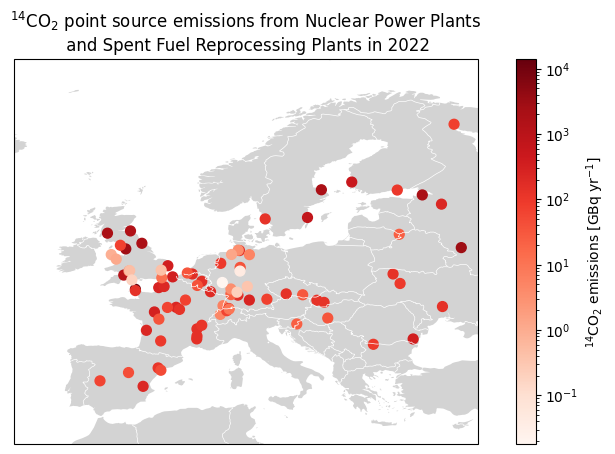

In [146]:
f, ax = plt.subplots(1,1,figsize=(10,5), subplot_kw={'projection': ccrs.PlateCarree()})

nuclear_emisisons_ICOS.plot(ax=ax, column='2022', cmap='Reds', legend=True, markersize=50, transform=ccrs.PlateCarree(), legend_kwds={'label': "$^{14}$CO$_2$ emissions [GBq yr$^{-1}$]"}, norm=LogNorm())

ax.add_feature(cfeature.LAND, facecolor='lightgrey')
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='white')
ax.set_extent([-15, 35, 33, 73])
ax.set_title('$^{14}$CO$_2$ point source emissions from Nuclear Power Plants\n and Spent Fuel Reprocessing Plants in 2022')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

f.savefig('figures/npp_point_source.png', dpi=300, bbox_inches='tight')

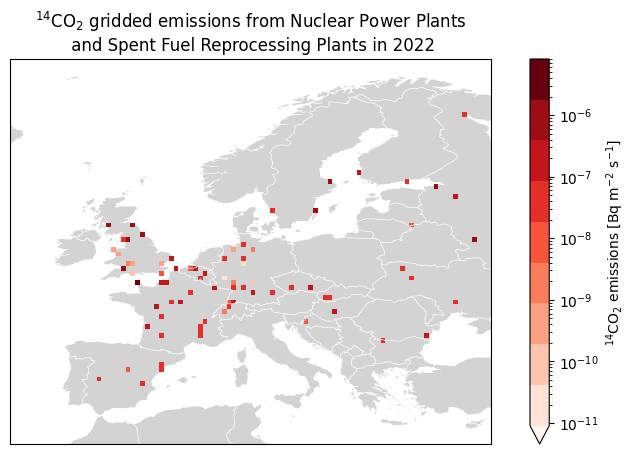

In [147]:
f, ax = plt.subplots(1,1,figsize=(10,5), subplot_kw={'projection': ccrs.PlateCarree()})

emis = npp['emis']

emis.attrs = {'units': 'Bq m$^{-2}$ s$^{-1}$',
              'long_name': '$^{14}$CO$_2$ emissions'}

log_levels = np.logspace(np.log10(emis.isel(time=15).values[emis.isel(time=15)>0].min()), np.log10(emis.isel(time=15).max()), num=10)

# Plot the data with a logarithmic color scale
emis.isel(time=15).plot.pcolormesh(ax=ax, x='lon', y='lat', norm=LogNorm(), cmap='Reds', levels=log_levels, vmin = log_levels.min(), vmax = log_levels.max())

ax.add_feature(cfeature.LAND, facecolor='lightgrey')
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='white')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.set_title('$^{14}$CO$_2$ gridded emissions from Nuclear Power Plants\n and Spent Fuel Reprocessing Plants in 2022')

f.savefig('figures/npp_gridded.png', dpi=300, bbox_inches='tight')

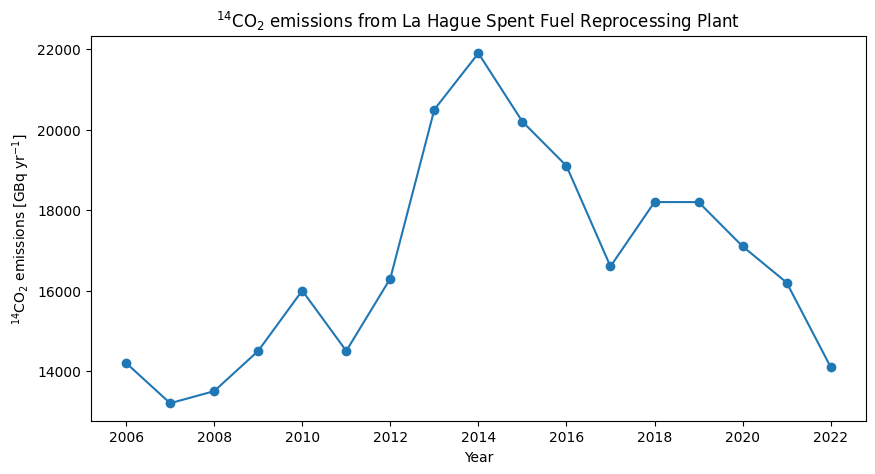

In [148]:
f, ax = plt.subplots(1,1,figsize=(10,5))

# npp['emis'].sel(lat=lat, lon=lon, method='nearest').plot(ax=ax)

lahague = nuclear_emisisons_ICOS.loc[nuclear_emisisons_ICOS['name']=='La Hague']
lahague.T.iloc[3:-1].plot(ax=ax, marker='o')#, label='La Hague')

ax.set_xlabel('Year')
ax.set_ylabel('$^{14}$CO$_2$ emissions [GBq yr$^{-1}$]')
ax.set_title('$^{14}$CO$_2$ emissions from La Hague Spent Fuel Reprocessing Plant')
#Remove the default legend
ax.legend_.remove()

f.savefig('figures/npp_timeseries_La_Hague.png', dpi=300, bbox_inches='tight')


## Global radiocarbon emissions from nuclear power facilities

The global emissions are derived from PRIS data using emission factors from [Graven & Gruber (2011)](https://doi.org/10.5194/acp-11-12339-2011) and [Zazzeri et al. (2018)](https://doi.org/10.1017/RDC.2018.42). If you are interested in emissions after 2023, you will have to run the web scraper in the notebook and update the metadata if new reactors are added.

In [149]:
rx_data_sum = pd.read_csv('data/reactors_all_PRIS_RADD_Zazzeri_Storm.csv')
rx_data_sum = gpd.GeoDataFrame(rx_data_sum, geometry=gpd.points_from_xy(rx_data_sum.Longitude, rx_data_sum.Latitude))

In [161]:
start = rx_data_sum.Year.unique().min()
end = rx_data_sum.Year.unique().max()

npp_time = pd.date_range(f'{start}-01-01', f'{end}-01-01', freq='AS')
npp_glb_reg = region(lat0=-90, lat1=90, lon0=-180, lon1=180, dlat=1, dlon=1)

In [162]:
# Create an empty xr.Dataset to store the NPP data
npp = xr.Dataset()

# Create a variable to store the NPP data
npp['emis'] = xr.DataArray(
    data = np.zeros((len(npp_time), len(npp_glb_reg.lats), len(npp_glb_reg.lons))),
    dims = ['time', 'lat', 'lon'],
    coords = {'time': npp_time, 'lat': npp_glb_reg.lats, 'lon': npp_glb_reg.lons},
    attrs = {'units': 'Bq/m2/s', 
             'long_name': '14CO2 emissions from Nuclear Power Plants and Spent Fuel Reprocessing Plants',
             'description': '14CO2 emissions from Nuclear Power Plants and Spent Fuel Reprocessing Plants preprocessed by Hannah Allen (hannah.allen@lsce.ipsl.fr) and Carlos Gómez-Ortiz on 2021-10-2023 with data from RADD and Zazzeri et al. (2018) gather and curated by Ida Storm (ida.storm@nateko.lu.se)',}
)

npp['emis'] = npp['emis'] / (365 * 24 * 60 * 60) # Convert from TBq yr-1 to TBq s-1
npp['emis'] = npp['emis'] * 1e12 # Convert from GBq s-1 to Bq s-1

for di, data in tqdm_notebook(rx_data_sum.iterrows(), total=rx_data_sum.shape[0]):

    lat = data.Latitude
    lon = data.Longitude

    lat_idx = np.argmin(abs(npp['lat'].values - lat))
    lon_idx = np.argmin(abs(npp['lon'].values - lon))
    yr = data.Year

    npp['emis'].values[yr-start, lat_idx, lon_idx] += data['Emission [TBq yr^-1]']

npp['emis'] = npp['emis'] / npp_glb_reg.area # Convert from Bq s-1 to Bq m-2 s-1

npp.to_netcdf('data/nuclear_emissions_global.nc')

/tmp/ipykernel_3495685/2120598461.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for di, data in tqdm_notebook(rx_data_sum.iterrows(), total=rx_data_sum.shape[0]):


  0%|          | 0/20807 [00:00<?, ?it/s]

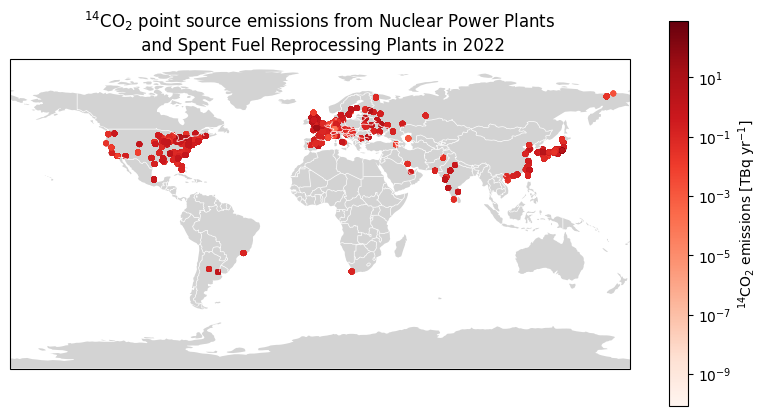

In [152]:
f, ax = plt.subplots(1,1,figsize=(10,5), subplot_kw={'projection': ccrs.PlateCarree()})

rx_data_2022 = rx_data_sum.loc[rx_data_sum['Year']==2022]
rx_data_sum.plot(ax=ax, column='Emission [TBq yr^-1]', cmap='Reds', legend=True, markersize=10, transform=ccrs.PlateCarree(), legend_kwds={'label': "$^{14}$CO$_2$ emissions [TBq yr$^{-1}$]"}, norm=LogNorm())

ax.add_feature(cfeature.LAND, facecolor='lightgrey')
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='white')
ax.set_extent([-180, 180, -90, 90])
ax.set_title('$^{14}$CO$_2$ point source emissions from Nuclear Power Plants\n and Spent Fuel Reprocessing Plants in 2022')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

f.savefig('figures/npp_point_source_global.png', dpi=300, bbox_inches='tight')

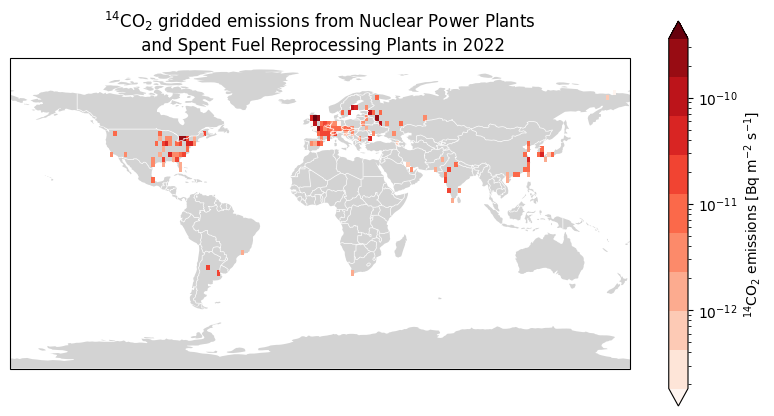

In [156]:
f, ax = plt.subplots(1,1,figsize=(10,5), subplot_kw={'projection': ccrs.PlateCarree()})

emis = npp['emis']

emis.attrs = {'units': 'Bq m$^{-2}$ s$^{-1}$',
              'long_name': '$^{14}$CO$_2$ emissions'}

log_levels = np.logspace(np.log10(emis.isel(time=15).values[emis.isel(time=15)>0].min()), np.log10(emis.isel(time=15).max()), num=10)

# Plot the data with a logarithmic color scale
emis.sel(time='2022-01-01').plot.pcolormesh(ax=ax, x='lon', y='lat', norm=LogNorm(), cmap='Reds', levels=log_levels, vmin = log_levels.min(), vmax = log_levels.max())

ax.add_feature(cfeature.LAND, facecolor='lightgrey')
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='white')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.set_title('$^{14}$CO$_2$ gridded emissions from Nuclear Power Plants\n and Spent Fuel Reprocessing Plants in 2022')

f.savefig('figures/npp_gridded_global.png', dpi=300, bbox_inches='tight')